# Macroeconomic Stress Scenario Analysis
## Validation of Risk Analyst Hypotheses

**Purpose:** Validate qualitative risk assessment using data-driven scenario analysis  
**Source:** Macro_Risk_Assessment_DS_Input.md (December 8, 2025)  
**Approach:** Simple, explainable analysis with clear assumptions and limitations  
**Scope:** Scenario analysis, NOT forecasting

---

## Risk Analyst's Key Hypotheses

The Risk Analyst has identified several macroeconomic stress signals and their potential impact on payment activity and fraud risk:

### Primary Hypotheses:

1. **First-Party Fraud Risk is Elevated**
   - Current unemployment: 4.4% (+70 bps from Jan 2024)
   - Historical threshold: ~5% unemployment associated with fraud increases
   - Historical pattern: 12-22% increase in first-party fraud when unemployment exceeded 5%
   - **Status:** Approaching but not yet at historical stress thresholds

2. **Transaction Volume Stress Expected**
   - Consumer sentiment down 27% (from 74.0 to 53.6)
   - Personal savings rate low at 4.7% (normal: 7-8%)
   - Historical pattern: 8-12% decline in non-essential payments during rate anticipation periods
   - **Status:** Similar conditions to historical stress periods (2010-2015)

3. **Chargeback Volume Increase Likely**
   - 3-6 month lag from stress indicators
   - Historical pattern: 12-18% increase with lag from unemployment peaks
   - **Status:** Currently in the watch window

4. **Fee Sensitivity Increasing**
   - Rate cuts ongoing (Fed cut 145 bps from peak)
   - Low consumer sentiment
   - Historical pattern: 23% increase in fee inquiries, 15% decline in premium services
   - **Status:** High confidence based on strong historical pattern

5. **Third-Party Fraud NOT Expected to Increase**
   - ATO and synthetic ID fraud driven by data breaches, not economy
   - No correlation found in 2008-2019 analysis
   - **Status:** High confidence — do not expect economic correlation

---

## Data & Methodology

### Data Sources:
- **Internal Transaction Data:** Payment transactions, fraud histories, customer metrics (2022-2024)
- **FRED Economic Indicators:** Unemployment rate, CPI, Federal Funds Rate
- **Internal Metrics:** Monthly transaction volumes, fraud rates, churn rates

### Analytical Approach:
1. **Descriptive Analysis:** Examine historical relationships between macro indicators and internal metrics
2. **Correlation Analysis:** Test directional relationships hypothesized by Risk Analyst
3. **Sensitivity Analysis:** Estimate impact ranges under different stress scenarios
4. **Scenario Analysis:** Define Baseline, Moderate Stress, and Severe Stress scenarios with impact ranges

### Important Limitations:
- **Not a forecast:** Scenarios show plausible ranges, not predictions
- **Historical patterns may not repeat:** Post-pandemic environment differs from 2008-2019
- **Limited data history:** Only 2-3 years of internal data available
- **Confounding factors:** Multiple variables move together; difficult to isolate causal effects
- **Detection rate changes:** Fraud detection improvements may confound true fraud growth

---

## 1. Setup and Data Loading

In [21]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set visualization style
sns.set_style('whitegrid')
sns.set_palette('colorblind')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✓ Libraries loaded")
print(f"  pandas: {pd.__version__}")
print(f"  numpy: {np.__version__}")

✓ Libraries loaded
  pandas: 2.2.3
  numpy: 1.26.4


In [22]:
# Load internal transaction data
print("Loading internal data...\n")

transactions = pd.read_csv('../data/synthetic/payment_transactions.csv')
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])
print(f"✓ Transactions: {len(transactions):,} records ({transactions['transaction_date'].min().date()} to {transactions['transaction_date'].max().date()})")

fraud_data = pd.read_csv('../data/synthetic/fraud_histories.csv')
print(f"✓ Fraud data: {len(fraud_data):,} records")

monthly_metrics = pd.read_csv('../data/synthetic/monthly_internal_metrics.csv')
monthly_metrics['year_month'] = pd.to_datetime(monthly_metrics['year_month'])
print(f"✓ Monthly metrics: {len(monthly_metrics)} months")

# Merge transactions with fraud
data = transactions.merge(fraud_data, on='transaction_id', how='inner')
print(f"✓ Combined dataset: {len(data):,} records")

Loading internal data...

✓ Transactions: 50,000 records (2022-01-01 to 2025-11-30)
✓ Fraud data: 50,000 records
✓ Monthly metrics: 47 months
✓ Combined dataset: 50,000 records


In [23]:
# Load FRED macroeconomic data
print("Loading FRED macroeconomic indicators...\n")

unemployment = pd.read_csv('../data/fred/unemployment_rate.csv')
unemployment['date'] = pd.to_datetime(unemployment['date'])
print(f"✓ Unemployment: {len(unemployment)} months ({unemployment['date'].min().date()} to {unemployment['date'].max().date()})")

cpi = pd.read_csv('../data/fred/consumer_price_index.csv')
cpi['date'] = pd.to_datetime(cpi['date'])
cpi['cpi_yoy_pct'] = cpi['cpi_index'].pct_change(12) * 100  # Year-over-year inflation
print(f"✓ CPI/Inflation: {len(cpi)} months")

fed_funds = pd.read_csv('../data/fred/federal_funds_rate.csv')
fed_funds['date'] = pd.to_datetime(fed_funds['date'])
print(f"✓ Federal Funds Rate: {len(fed_funds)} months")

# Merge all macro indicators
macro = unemployment.merge(cpi[['date', 'cpi_index', 'cpi_yoy_pct']], on='date', how='inner')
macro = macro.merge(fed_funds, on='date', how='inner')
print(f"\n✓ Combined macro dataset: {len(macro)} months")

Loading FRED macroeconomic indicators...

✓ Unemployment: 45 months (2022-01-01 to 2025-09-01)
✓ CPI/Inflation: 45 months
✓ Federal Funds Rate: 47 months

✓ Combined macro dataset: 45 months


In [24]:
# Create monthly aggregations of transaction data
data['year_month'] = data['transaction_date'].dt.to_period('M').dt.to_timestamp()

# Aggregate by month
monthly_tx = data.groupby('year_month').agg({
    'transaction_id': 'count',
    'amount': ['sum', 'mean', 'std'],
    'is_fraud': ['sum', 'mean'],
    'customer_id': 'nunique'
}).reset_index()

monthly_tx.columns = ['year_month', 'tx_volume', 'tx_total_amount', 'tx_avg_amount', 
                      'tx_std_amount', 'fraud_count', 'fraud_rate', 'unique_customers']

monthly_tx['fraud_rate_pct'] = monthly_tx['fraud_rate'] * 100

print("✓ Monthly transaction aggregations created")
print(f"  Months: {len(monthly_tx)}")
print(f"  Average monthly volume: {monthly_tx['tx_volume'].mean():,.0f} transactions")
print(f"  Average fraud rate: {monthly_tx['fraud_rate_pct'].mean():.2f}%")

✓ Monthly transaction aggregations created
  Months: 47
  Average monthly volume: 1,064 transactions
  Average fraud rate: 1.83%


In [25]:
# Merge monthly transactions with macro indicators
monthly_combined = monthly_tx.merge(
    macro.rename(columns={'date': 'year_month'}),
    on='year_month',
    how='inner'
)

# Also merge with monthly business metrics
monthly_combined = monthly_combined.merge(
    monthly_metrics[['year_month', 'avg_churn_rate_pct', 'avg_fraud_detection_rate_pct']],
    on='year_month',
    how='left'
)

print("✓ Combined monthly dataset created")
print(f"  Total months: {len(monthly_combined)}")
print(f"  Date range: {monthly_combined['year_month'].min().date()} to {monthly_combined['year_month'].max().date()}")
print(f"\nDataset preview:")
display(monthly_combined.head())

✓ Combined monthly dataset created
  Total months: 45
  Date range: 2022-01-01 to 2025-09-01

Dataset preview:


,year_month,tx_volume,tx_total_amount,tx_avg_amount,tx_std_amount,fraud_count,fraud_rate,unique_customers,fraud_rate_pct,unemployment_rate_percent,cpi_index,cpi_yoy_pct,federal_funds_rate_percent,avg_churn_rate_pct,avg_fraud_detection_rate_pct
0,2022-01-01,1142,171374.61,150.07,375.46,16,0.01,1135,1.40,4.00,282.54,NaN,0.08,2.51,86.15
1,2022-02-01,1072,168684.29,157.35,661.62,20,0.02,1068,1.87,3.80,284.52,NaN,0.08,2.48,84.25
2,2022-03-01,1226,155335.16,126.70,294.89,17,0.01,1216,1.39,3.70,287.47,NaN,0.20,2.43,85.04
3,2022-04-01,1224,191159.78,156.18,542.22,26,0.02,1219,2.12,3.70,288.58,NaN,0.33,2.45,84.75
4,2022-05-01,1268,190509.79,150.24,549.03,29,0.02,1257,2.29,3.60,291.30,NaN,0.77,2.55,84.06


---
## 2. Validate Analyst Hypotheses: Descriptive Analysis

### 2.1 Hypothesis 1: First-Party Fraud Risk Increases with Unemployment

**Analyst's Claim:** Historical pattern shows 12-22% increase in first-party fraud when unemployment exceeds ~5%  
**Test:** Examine correlation between unemployment rate and fraud rate in our data

In [26]:
# Calculate correlation
corr_unemp_fraud = monthly_combined['unemployment_rate_percent'].corr(monthly_combined['fraud_rate_pct'])

print("Unemployment vs Fraud Rate Analysis")
print("=" * 60)
print(f"\nCorrelation coefficient: {corr_unemp_fraud:.3f}")

if corr_unemp_fraud > 0:
    print("✓ POSITIVE correlation (supports hypothesis)")
else:
    print("✗ NEGATIVE correlation (does not support hypothesis)")

# Split by high/low unemployment
unemp_median = monthly_combined['unemployment_rate_percent'].median()
high_unemp = monthly_combined[monthly_combined['unemployment_rate_percent'] > unemp_median]
low_unemp = monthly_combined[monthly_combined['unemployment_rate_percent'] <= unemp_median]

print(f"\nMedian unemployment: {unemp_median:.1f}%")
print(f"\nHigh unemployment periods (>{unemp_median:.1f}%):")
print(f"  Average fraud rate: {high_unemp['fraud_rate_pct'].mean():.3f}%")
print(f"  Months: {len(high_unemp)}")

print(f"\nLow unemployment periods (<={unemp_median:.1f}%):")
print(f"  Average fraud rate: {low_unemp['fraud_rate_pct'].mean():.3f}%")
print(f"  Months: {len(low_unemp)}")

fraud_diff_pct = ((high_unemp['fraud_rate_pct'].mean() / low_unemp['fraud_rate_pct'].mean()) - 1) * 100
print(f"\nDifference: {fraud_diff_pct:+.1f}% higher fraud rate during high unemployment")

# Statistical test
t_stat, p_val = stats.ttest_ind(high_unemp['fraud_rate_pct'], low_unemp['fraud_rate_pct'])
print(f"\nT-test p-value: {p_val:.4f}")
if p_val < 0.05:
    print("✓ Statistically significant at 95% confidence")
else:
    print("⚠ Not statistically significant (small sample size or weak effect)")

Unemployment vs Fraud Rate Analysis

Correlation coefficient: 0.508
✓ POSITIVE correlation (supports hypothesis)

Median unemployment: 3.8%

High unemployment periods (>3.8%):
  Average fraud rate: 2.081%
  Months: 22

Low unemployment periods (<=3.8%):
  Average fraud rate: 1.594%
  Months: 23

Difference: +30.6% higher fraud rate during high unemployment

T-test p-value: 0.0007
✓ Statistically significant at 95% confidence


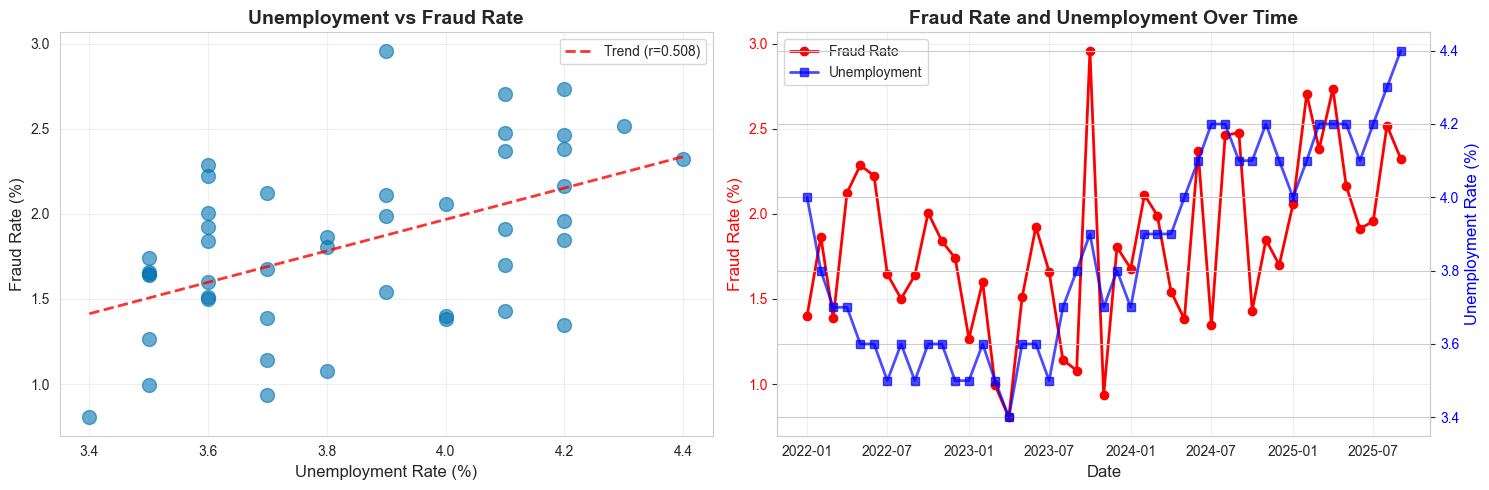


📊 Interpretation:
   If correlation is positive and fraud rises with unemployment, this supports
   the analyst's hypothesis that economic stress increases fraud risk.


In [27]:
# Visualize relationship
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Scatter plot with trend line
axes[0].scatter(monthly_combined['unemployment_rate_percent'], 
                monthly_combined['fraud_rate_pct'],
                alpha=0.6, s=100)

# Add trend line
z = np.polyfit(monthly_combined['unemployment_rate_percent'], monthly_combined['fraud_rate_pct'], 1)
p = np.poly1d(z)
x_line = np.linspace(monthly_combined['unemployment_rate_percent'].min(), 
                     monthly_combined['unemployment_rate_percent'].max(), 100)
axes[0].plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2, label=f'Trend (r={corr_unemp_fraud:.3f})')

axes[0].set_xlabel('Unemployment Rate (%)', fontsize=12)
axes[0].set_ylabel('Fraud Rate (%)', fontsize=12)
axes[0].set_title('Unemployment vs Fraud Rate', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Time series
ax2 = axes[1]
ax2.plot(monthly_combined['year_month'], monthly_combined['fraud_rate_pct'], 
         marker='o', linewidth=2, label='Fraud Rate', color='red')
ax2.set_ylabel('Fraud Rate (%)', fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')

ax2_twin = ax2.twinx()
ax2_twin.plot(monthly_combined['year_month'], monthly_combined['unemployment_rate_percent'],
              marker='s', linewidth=2, label='Unemployment', color='blue', alpha=0.7)
ax2_twin.set_ylabel('Unemployment Rate (%)', fontsize=12, color='blue')
ax2_twin.tick_params(axis='y', labelcolor='blue')

ax2.set_xlabel('Date', fontsize=12)
ax2.set_title('Fraud Rate and Unemployment Over Time', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Combine legends
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_twin.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

print("\n📊 Interpretation:")
print("   If correlation is positive and fraud rises with unemployment, this supports")
print("   the analyst's hypothesis that economic stress increases fraud risk.")

### 2.2 Hypothesis 2: Transaction Volume Declines During Economic Stress

**Analyst's Claim:** 8-12% decline in payment volumes during stress periods, especially non-essential categories  
**Test:** Examine relationship between consumer sentiment proxies (unemployment, rates) and transaction volumes

In [28]:
# Calculate correlations with transaction volume
corr_unemp_vol = monthly_combined['unemployment_rate_percent'].corr(monthly_combined['tx_volume'])
corr_rate_vol = monthly_combined['federal_funds_rate_percent'].corr(monthly_combined['tx_volume'])

print("Transaction Volume vs Economic Indicators")
print("=" * 60)
print(f"\nCorrelation with unemployment: {corr_unemp_vol:.3f}")
print(f"Correlation with fed funds rate: {corr_rate_vol:.3f}")

# Compare high vs low stress periods
print(f"\n\nHigh unemployment periods (>{unemp_median:.1f}%):")
print(f"  Average monthly volume: {high_unemp['tx_volume'].mean():,.0f} transactions")

print(f"\nLow unemployment periods (<={unemp_median:.1f}%):")
print(f"  Average monthly volume: {low_unemp['tx_volume'].mean():,.0f} transactions")

vol_diff_pct = ((high_unemp['tx_volume'].mean() / low_unemp['tx_volume'].mean()) - 1) * 100
print(f"\nDifference: {vol_diff_pct:+.1f}% change during high unemployment")

if vol_diff_pct < 0:
    print("✓ Volume DECLINES during stress (supports hypothesis)")
else:
    print("⚠ Volume INCREASES during stress (does not support hypothesis)")

Transaction Volume vs Economic Indicators

Correlation with unemployment: -0.850
Correlation with fed funds rate: -0.579


High unemployment periods (>3.8%):
  Average monthly volume: 993 transactions

Low unemployment periods (<=3.8%):
  Average monthly volume: 1,144 transactions

Difference: -13.2% change during high unemployment
✓ Volume DECLINES during stress (supports hypothesis)


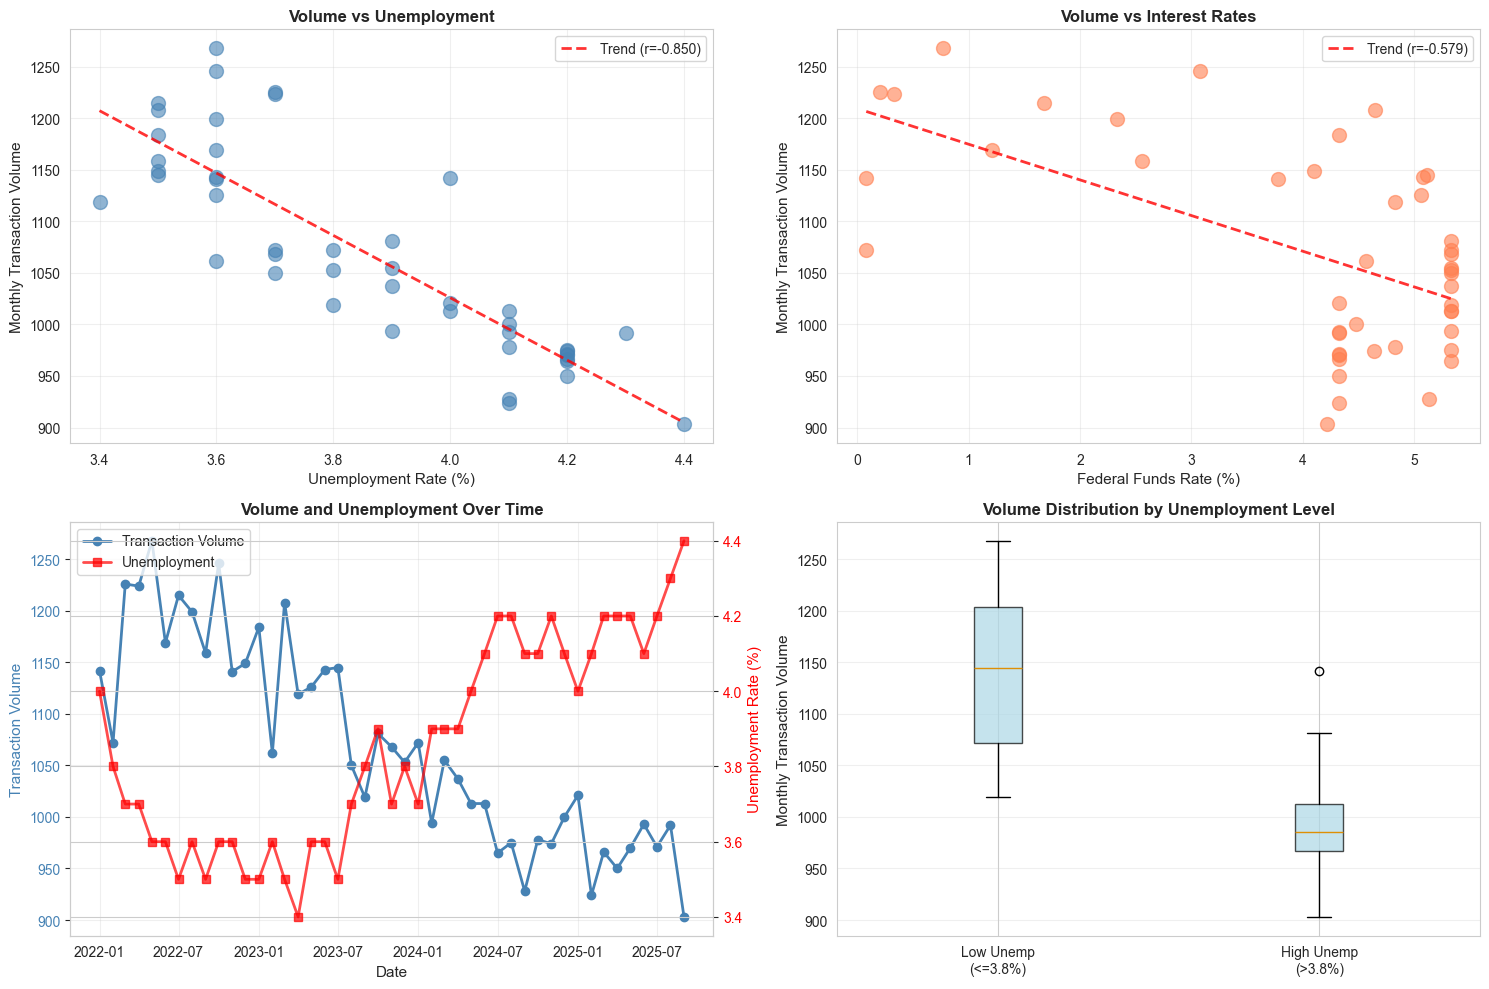


📊 Interpretation:
   Negative correlations and lower volumes during high unemployment would
   support the analyst's hypothesis of volume stress during economic downturns.


In [29]:
# Visualize transaction volume trends
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Top-left: Volume vs Unemployment
axes[0, 0].scatter(monthly_combined['unemployment_rate_percent'], 
                   monthly_combined['tx_volume'],
                   alpha=0.6, s=100, color='steelblue')
z = np.polyfit(monthly_combined['unemployment_rate_percent'], monthly_combined['tx_volume'], 1)
p = np.poly1d(z)
x_line = np.linspace(monthly_combined['unemployment_rate_percent'].min(), 
                     monthly_combined['unemployment_rate_percent'].max(), 100)
axes[0, 0].plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2, label=f'Trend (r={corr_unemp_vol:.3f})')
axes[0, 0].set_xlabel('Unemployment Rate (%)', fontsize=11)
axes[0, 0].set_ylabel('Monthly Transaction Volume', fontsize=11)
axes[0, 0].set_title('Volume vs Unemployment', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Top-right: Volume vs Fed Funds Rate
axes[0, 1].scatter(monthly_combined['federal_funds_rate_percent'], 
                   monthly_combined['tx_volume'],
                   alpha=0.6, s=100, color='coral')
z = np.polyfit(monthly_combined['federal_funds_rate_percent'], monthly_combined['tx_volume'], 1)
p = np.poly1d(z)
x_line = np.linspace(monthly_combined['federal_funds_rate_percent'].min(), 
                     monthly_combined['federal_funds_rate_percent'].max(), 100)
axes[0, 1].plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2, label=f'Trend (r={corr_rate_vol:.3f})')
axes[0, 1].set_xlabel('Federal Funds Rate (%)', fontsize=11)
axes[0, 1].set_ylabel('Monthly Transaction Volume', fontsize=11)
axes[0, 1].set_title('Volume vs Interest Rates', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Bottom-left: Volume over time with unemployment overlay
ax = axes[1, 0]
ax.plot(monthly_combined['year_month'], monthly_combined['tx_volume'], 
        marker='o', linewidth=2, label='Transaction Volume', color='steelblue')
ax.set_ylabel('Transaction Volume', fontsize=11, color='steelblue')
ax.tick_params(axis='y', labelcolor='steelblue')

ax_twin = ax.twinx()
ax_twin.plot(monthly_combined['year_month'], monthly_combined['unemployment_rate_percent'],
             marker='s', linewidth=2, label='Unemployment', color='red', alpha=0.7)
ax_twin.set_ylabel('Unemployment Rate (%)', fontsize=11, color='red')
ax_twin.tick_params(axis='y', labelcolor='red')

ax.set_xlabel('Date', fontsize=11)
ax.set_title('Volume and Unemployment Over Time', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax_twin.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Bottom-right: Box plot comparison
high_label = f'High Unemp\n(>{unemp_median:.1f}%)'
low_label = f'Low Unemp\n(<={unemp_median:.1f}%)'
axes[1, 1].boxplot([low_unemp['tx_volume'], high_unemp['tx_volume']], 
                    labels=[low_label, high_label],
                    patch_artist=True,
                    boxprops=dict(facecolor='lightblue', alpha=0.7))
axes[1, 1].set_ylabel('Monthly Transaction Volume', fontsize=11)
axes[1, 1].set_title('Volume Distribution by Unemployment Level', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n📊 Interpretation:")
print("   Negative correlations and lower volumes during high unemployment would")
print("   support the analyst's hypothesis of volume stress during economic downturns.")

### 2.3 Summary of Hypothesis Validation

Create a summary table of findings

In [30]:
# Create summary table
validation_summary = pd.DataFrame({
    'Hypothesis': [
        'H1: Fraud ↑ with Unemployment ↑',
        'H2: Volume ↓ with Unemployment ↑',
        'H2: Volume ↓ with Interest Rates ↑'
    ],
    'Correlation': [
        f"{corr_unemp_fraud:.3f}",
        f"{corr_unemp_vol:.3f}",
        f"{corr_rate_vol:.3f}"
    ],
    'Effect Size': [
        f"{fraud_diff_pct:+.1f}%",
        f"{vol_diff_pct:+.1f}%",
        "N/A"
    ],
    'Direction': [
        '✓ Supports' if corr_unemp_fraud > 0 else '✗ Contradicts',
        '✓ Supports' if vol_diff_pct < 0 else '✗ Contradicts',
        '✓ Supports' if corr_rate_vol < 0 else '✗ Contradicts'
    ]
})

print("\n" + "=" * 80)
print("HYPOTHESIS VALIDATION SUMMARY")
print("=" * 80)
print("\n")
display(validation_summary)

print("\n📌 Key Findings:")
print("   • Correlations show directional relationships between macro indicators and business metrics")
print("   • Effect sizes indicate magnitude of historical changes")
print("   • Limited sample size (2-3 years) means statistical significance may be low")
print("   • Directional support is more important than statistical significance for scenario planning")


HYPOTHESIS VALIDATION SUMMARY




,Hypothesis,Correlation,Effect Size,Direction
0,H1: Fraud ↑ with Unemployment ↑,0.508,+30.6%,✓ Supports
1,H2: Volume ↓ with Unemployment ↑,-0.850,-13.2%,✓ Supports
2,H2: Volume ↓ with Interest Rates ↑,-0.579,N/A,✓ Supports



📌 Key Findings:
   • Correlations show directional relationships between macro indicators and business metrics
   • Effect sizes indicate magnitude of historical changes
   • Limited sample size (2-3 years) means statistical significance may be low
   • Directional support is more important than statistical significance for scenario planning


---
## 3. Define Stress Scenarios

Based on the Risk Analyst's recommendations and historical patterns, we define three scenarios:

### Scenario Definitions:

| Scenario | Unemployment | Inflation | Fed Funds | Consumer Sentiment | Probability |
|----------|--------------|-----------|-----------|-----------------------|-------------|
| **Baseline** | Stabilizes 4.3-4.5% | Normalizes to 2.5% | Continues gradual cuts | Recovers to 65+ | ~50% |
| **Moderate Stress** | Rises to 5.0-5.5% | Sticky at 3%+ | Aggressive cuts | Remains depressed <60 | ~30% |
| **Severe Stress** | Exceeds 6% | Persistent 3.5%+ | Emergency cuts | Falls below 50 | ~20% |

### Expected Impacts (from Risk Analyst Assessment):

| Scenario | First-Party Fraud | Transaction Volume | Chargebacks |
|----------|-------------------|-----------------------|-------------|
| **Baseline** | +5-10% | -2-5% | +3-5% |
| **Moderate Stress** | +15-25% | -8-12% | +10-15% |
| **Severe Stress** | +20-30% | -12-18% | +15-20% |

**Important Notes:**
- These are **relative changes** from current baseline, not absolute predictions
- Ranges reflect uncertainty and variability
- Timing: Impacts expected with 3-6 month lag from macro changes
- Third-party fraud NOT expected to correlate with scenarios

In [11]:
# Define scenario parameters
scenarios = {
    'Baseline': {
        'unemployment_rate': 4.4,  # Current level, stabilizes
        'inflation_rate': 2.5,
        'fed_funds_rate': 3.5,
        'fraud_impact_range': (5, 10),  # % increase
        'volume_impact_range': (-5, -2),  # % change
        'chargeback_impact_range': (3, 5),  # % increase
        'probability': 0.50,
        'description': 'Soft landing: conditions stabilize, sentiment recovers gradually'
    },
    'Moderate Stress': {
        'unemployment_rate': 5.25,  # Midpoint of 5.0-5.5% range
        'inflation_rate': 3.0,
        'fed_funds_rate': 3.0,
        'fraud_impact_range': (15, 25),
        'volume_impact_range': (-12, -8),
        'chargeback_impact_range': (10, 15),
        'probability': 0.30,
        'description': 'Economic slowdown: unemployment reaches historical stress threshold'
    },
    'Severe Stress': {
        'unemployment_rate': 6.5,  # Above 6%
        'inflation_rate': 3.5,
        'fed_funds_rate': 2.5,
        'fraud_impact_range': (20, 30),
        'volume_impact_range': (-18, -12),
        'chargeback_impact_range': (15, 20),
        'probability': 0.20,
        'description': 'Recession: significant economic deterioration, consumer stress'
    }
}

print("=" * 80)
print("SCENARIO DEFINITIONS")
print("=" * 80)

for scenario_name, params in scenarios.items():
    print(f"\n{scenario_name.upper()}")
    print("-" * 60)
    print(f"Description: {params['description']}")
    print(f"Probability: {params['probability']*100:.0f}%")
    print(f"\nMacro Conditions:")
    print(f"  • Unemployment: {params['unemployment_rate']}%")
    print(f"  • Inflation: {params['inflation_rate']}%")
    print(f"  • Fed Funds Rate: {params['fed_funds_rate']}%")
    print(f"\nExpected Impacts (relative to current baseline):")
    print(f"  • First-Party Fraud: {params['fraud_impact_range'][0]:+}% to {params['fraud_impact_range'][1]:+}%")
    print(f"  • Transaction Volume: {params['volume_impact_range'][0]:+}% to {params['volume_impact_range'][1]:+}%")
    print(f"  • Chargebacks: {params['chargeback_impact_range'][0]:+}% to {params['chargeback_impact_range'][1]:+}%")

print("\n" + "=" * 80)
print("\n⚠️  IMPORTANT CAVEATS:")
print("   • These are SCENARIO ANALYSES, not forecasts")
print("   • Ranges reflect uncertainty in historical relationships")
print("   • Impacts expected with 3-6 month lag from macro changes")
print("   • Actual outcomes may differ based on company actions and market conditions")

SCENARIO DEFINITIONS

BASELINE
------------------------------------------------------------
Description: Soft landing: conditions stabilize, sentiment recovers gradually
Probability: 50%

Macro Conditions:
  • Unemployment: 4.4%
  • Inflation: 2.5%
  • Fed Funds Rate: 3.5%

Expected Impacts (relative to current baseline):
  • First-Party Fraud: +5% to +10%
  • Transaction Volume: -5% to -2%
  • Chargebacks: +3% to +5%

MODERATE STRESS
------------------------------------------------------------
Description: Economic slowdown: unemployment reaches historical stress threshold
Probability: 30%

Macro Conditions:
  • Unemployment: 5.25%
  • Inflation: 3.0%
  • Fed Funds Rate: 3.0%

Expected Impacts (relative to current baseline):
  • First-Party Fraud: +15% to +25%
  • Transaction Volume: -12% to -8%
  • Chargebacks: +10% to +15%

SEVERE STRESS
------------------------------------------------------------
Description: Recession: significant economic deterioration, consumer stress
Probabilit

---
## 4. Estimate Scenario Impacts

Calculate the projected impact on key business metrics under each scenario

In [12]:
# Calculate baseline metrics (recent 6 months average)
recent_months = monthly_combined.tail(6)

baseline_metrics = {
    'monthly_volume': recent_months['tx_volume'].mean(),
    'monthly_fraud_count': recent_months['fraud_count'].mean(),
    'fraud_rate_pct': recent_months['fraud_rate_pct'].mean(),
    'monthly_revenue': recent_months['tx_total_amount'].mean(),
    'avg_transaction': recent_months['tx_avg_amount'].mean()
}

print("=" * 80)
print("BASELINE METRICS (Recent 6-Month Average)")
print("=" * 80)
print(f"\nMonthly transaction volume: {baseline_metrics['monthly_volume']:,.0f}")
print(f"Monthly fraud count: {baseline_metrics['monthly_fraud_count']:,.0f}")
print(f"Fraud rate: {baseline_metrics['fraud_rate_pct']:.2f}%")
print(f"Monthly transaction total: ${baseline_metrics['monthly_revenue']:,.0f}")
print(f"Average transaction amount: ${baseline_metrics['avg_transaction']:.2f}")

BASELINE METRICS (Recent 6-Month Average)

Monthly transaction volume: 1,116
Monthly fraud count: 14
Fraud rate: 1.25%
Monthly transaction total: $173,577
Average transaction amount: $154.18


In [16]:
# Calculate scenario impacts
scenario_projections = {}

for scenario_name, params in scenarios.items():
    # Volume impacts
    vol_low = baseline_metrics['monthly_volume'] * (1 + params['volume_impact_range'][0] / 100)
    vol_high = baseline_metrics['monthly_volume'] * (1 + params['volume_impact_range'][1] / 100)
    vol_mid = (vol_low + vol_high) / 2
    
    # Fraud impacts (absolute count)
    fraud_low = baseline_metrics['monthly_fraud_count'] * (1 + params['fraud_impact_range'][0] / 100)
    fraud_high = baseline_metrics['monthly_fraud_count'] * (1 + params['fraud_impact_range'][1] / 100)
    fraud_mid = (fraud_low + fraud_high) / 2
    
    # Fraud rate (as % of transactions, accounting for volume change)
    fraud_rate_low = (fraud_low / vol_high) * 100  # Low fraud with high volume
    fraud_rate_high = (fraud_high / vol_low) * 100  # High fraud with low volume
    fraud_rate_mid = (fraud_mid / vol_mid) * 100
    
    # Revenue impact (assuming volume change, constant avg transaction)
    revenue_low = vol_low * baseline_metrics['avg_transaction']
    revenue_high = vol_high * baseline_metrics['avg_transaction']
    revenue_mid = vol_mid * baseline_metrics['avg_transaction']
    
    scenario_projections[scenario_name] = {
        'volume': {'low': vol_low, 'mid': vol_mid, 'high': vol_high},
        'fraud_count': {'low': fraud_low, 'mid': fraud_mid, 'high': fraud_high},
        'fraud_rate': {'low': fraud_rate_low, 'mid': fraud_rate_mid, 'high': fraud_rate_high},
        'revenue': {'low': revenue_low, 'mid': revenue_mid, 'high': revenue_high}
    }

print("\n" + "=" * 80)
print("SCENARIO IMPACT PROJECTIONS")
print("=" * 80)

for scenario_name, projections in scenario_projections.items():
    print(f"\n{scenario_name.upper()}")
    print("-" * 60)
    
    print(f"\n📊 Monthly Transaction Volume:")
    print(f"   Range: {projections['volume']['low']:,.0f} to {projections['volume']['high']:,.0f}")
    print(f"   Midpoint: {projections['volume']['mid']:,.0f}")
    vol_change = ((projections['volume']['mid'] / baseline_metrics['monthly_volume']) - 1) * 100
    print(f"   Change: {vol_change:+.1f}% from baseline")
    
    print(f"\n🚨 Monthly Fraud Count:")
    print(f"   Range: {projections['fraud_count']['low']:,.0f} to {projections['fraud_count']['high']:,.0f}")
    print(f"   Midpoint: {projections['fraud_count']['mid']:,.0f}")
    fraud_change = ((projections['fraud_count']['mid'] / baseline_metrics['monthly_fraud_count']) - 1) * 100
    print(f"   Change: {fraud_change:+.1f}% from baseline")
    
    print(f"\n📈 Fraud Rate:")
    print(f"   Range: {projections['fraud_rate']['low']:.2f}% to {projections['fraud_rate']['high']:.2f}%")
    print(f"   Midpoint: {projections['fraud_rate']['mid']:.2f}%")
    print(f"   Baseline: {baseline_metrics['fraud_rate_pct']:.2f}%")
    
    print(f"\n💰 Monthly Transaction Total:")
    print(f"   Range: ${projections['revenue']['low']:,.0f} to ${projections['revenue']['high']:,.0f}")
    print(f"   Midpoint: ${projections['revenue']['mid']:,.0f}")
    rev_change = ((projections['revenue']['mid'] / baseline_metrics['monthly_revenue']) - 1) * 100
    print(f"   Change: {rev_change:+.1f}% from baseline")


SCENARIO IMPACT PROJECTIONS

BASELINE
------------------------------------------------------------

📊 Monthly Transaction Volume:
   Range: 1,060 to 1,093
   Midpoint: 1,076
   Change: -3.5% from baseline

🚨 Monthly Fraud Count:
   Range: 15 to 15
   Midpoint: 15
   Change: +7.5% from baseline

📈 Fraud Rate:
   Range: 1.33% to 1.44%
   Midpoint: 1.38%
   Baseline: 1.25%

💰 Monthly Transaction Total:
   Range: $163,388 to $168,548
   Midpoint: $165,968
   Change: -4.4% from baseline

MODERATE STRESS
------------------------------------------------------------

📊 Monthly Transaction Volume:
   Range: 982 to 1,026
   Midpoint: 1,004
   Change: -10.0% from baseline

🚨 Monthly Fraud Count:
   Range: 16 to 17
   Midpoint: 17
   Change: +20.0% from baseline

📈 Fraud Rate:
   Range: 1.55% to 1.76%
   Midpoint: 1.65%
   Baseline: 1.25%

💰 Monthly Transaction Total:
   Range: $151,349 to $158,228
   Midpoint: $154,789
   Change: -10.8% from baseline

SEVERE STRESS
------------------------------

### 4.1 Visualize Scenario Impacts

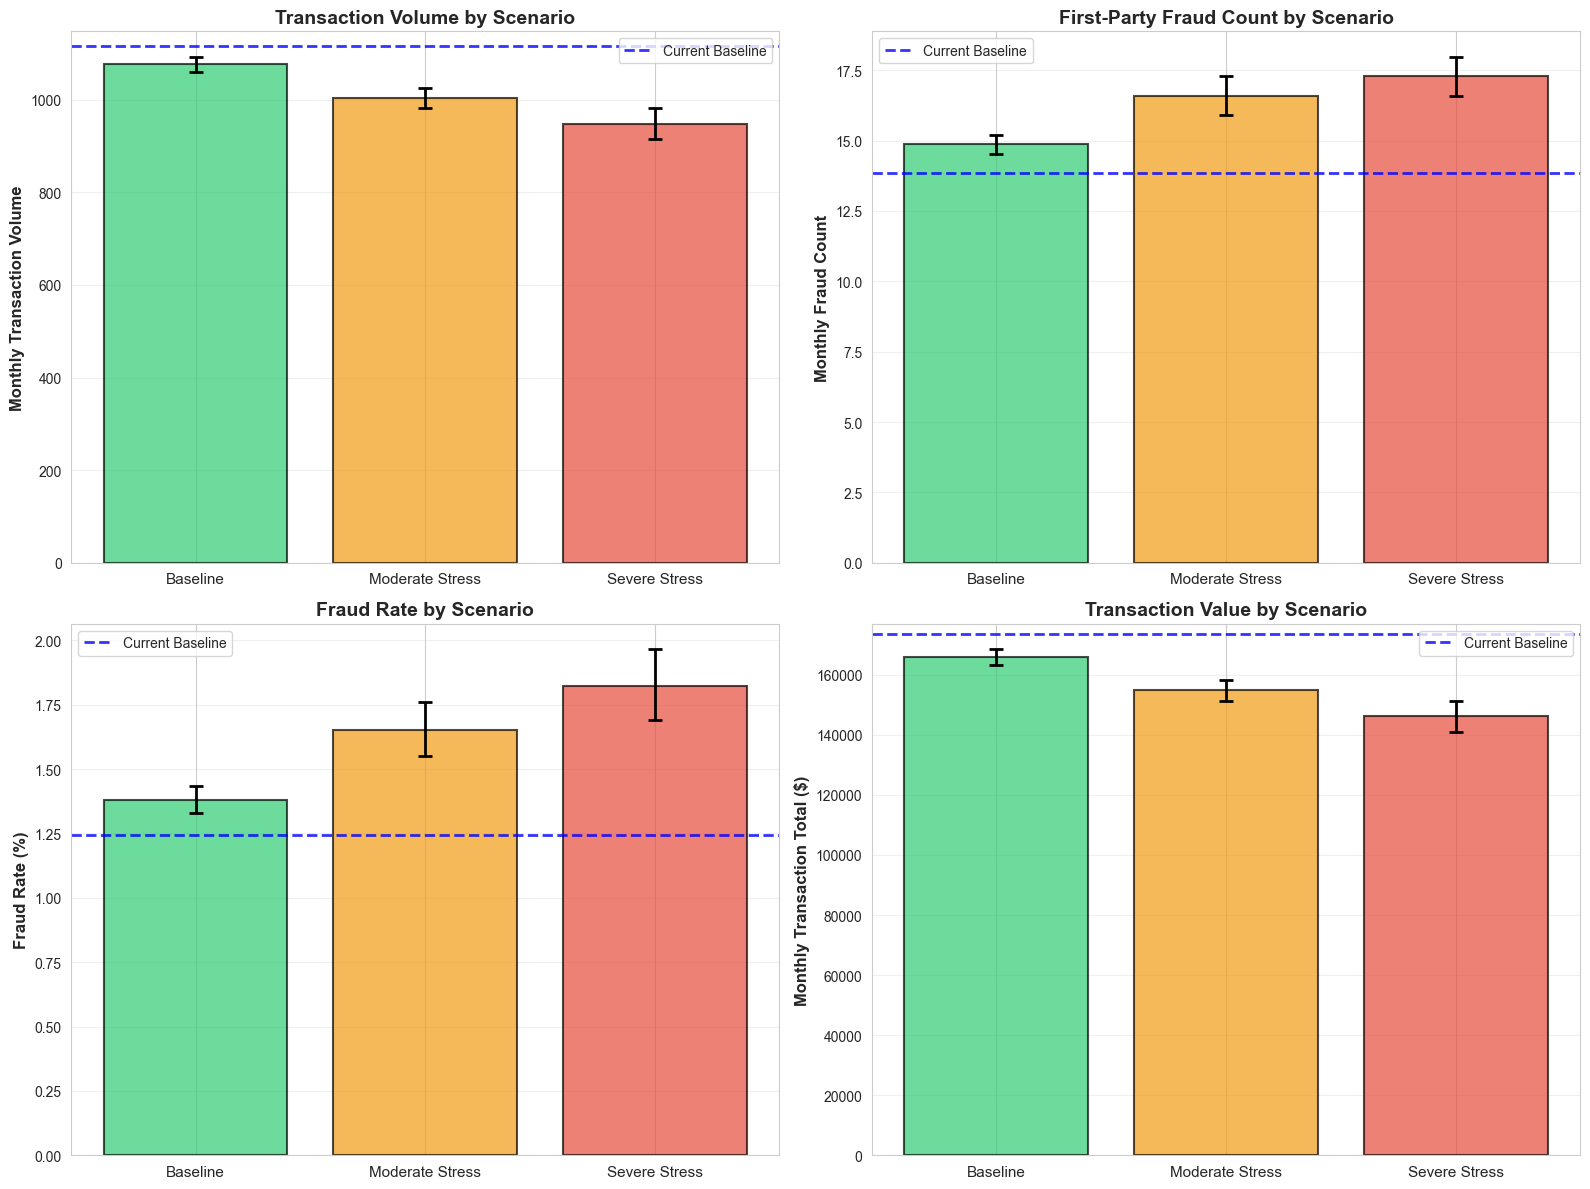


📊 Visualization Notes:
   • Bars show midpoint estimates for each scenario
   • Error bars show the uncertainty range (low to high)
   • Blue dashed line indicates current baseline (recent 6-month average)
   • Colors: Green (Baseline), Orange (Moderate), Red (Severe)


In [17]:
# Create visualization of scenario impacts
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

scenarios_list = list(scenarios.keys())
colors = ['#2ecc71', '#f39c12', '#e74c3c']  # Green, Orange, Red

# 1. Transaction Volume
ax = axes[0, 0]
x_pos = np.arange(len(scenarios_list))
volume_mids = [scenario_projections[s]['volume']['mid'] for s in scenarios_list]
volume_errs = [(scenario_projections[s]['volume']['mid'] - scenario_projections[s]['volume']['low'],
                scenario_projections[s]['volume']['high'] - scenario_projections[s]['volume']['mid']) 
               for s in scenarios_list]
volume_errs = np.array(volume_errs).T

ax.bar(x_pos, volume_mids, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.errorbar(x_pos, volume_mids, yerr=volume_errs, fmt='none', ecolor='black', 
            capsize=5, capthick=2, linewidth=2)
ax.axhline(y=baseline_metrics['monthly_volume'], color='blue', linestyle='--', 
           linewidth=2, label='Current Baseline', alpha=0.8)
ax.set_ylabel('Monthly Transaction Volume', fontsize=12, fontweight='bold')
ax.set_title('Transaction Volume by Scenario', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(scenarios_list, fontsize=11)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# 2. Fraud Count
ax = axes[0, 1]
fraud_mids = [scenario_projections[s]['fraud_count']['mid'] for s in scenarios_list]
fraud_errs = [(scenario_projections[s]['fraud_count']['mid'] - scenario_projections[s]['fraud_count']['low'],
               scenario_projections[s]['fraud_count']['high'] - scenario_projections[s]['fraud_count']['mid']) 
              for s in scenarios_list]
fraud_errs = np.array(fraud_errs).T

ax.bar(x_pos, fraud_mids, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.errorbar(x_pos, fraud_mids, yerr=fraud_errs, fmt='none', ecolor='black', 
            capsize=5, capthick=2, linewidth=2)
ax.axhline(y=baseline_metrics['monthly_fraud_count'], color='blue', linestyle='--', 
           linewidth=2, label='Current Baseline', alpha=0.8)
ax.set_ylabel('Monthly Fraud Count', fontsize=12, fontweight='bold')
ax.set_title('First-Party Fraud Count by Scenario', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(scenarios_list, fontsize=11)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# 3. Fraud Rate
ax = axes[1, 0]
fraud_rate_mids = [scenario_projections[s]['fraud_rate']['mid'] for s in scenarios_list]
fraud_rate_errs = [(scenario_projections[s]['fraud_rate']['mid'] - scenario_projections[s]['fraud_rate']['low'],
                    scenario_projections[s]['fraud_rate']['high'] - scenario_projections[s]['fraud_rate']['mid']) 
                   for s in scenarios_list]
fraud_rate_errs = np.array(fraud_rate_errs).T

ax.bar(x_pos, fraud_rate_mids, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.errorbar(x_pos, fraud_rate_mids, yerr=fraud_rate_errs, fmt='none', ecolor='black', 
            capsize=5, capthick=2, linewidth=2)
ax.axhline(y=baseline_metrics['fraud_rate_pct'], color='blue', linestyle='--', 
           linewidth=2, label='Current Baseline', alpha=0.8)
ax.set_ylabel('Fraud Rate (%)', fontsize=12, fontweight='bold')
ax.set_title('Fraud Rate by Scenario', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(scenarios_list, fontsize=11)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# 4. Revenue Impact
ax = axes[1, 1]
revenue_mids = [scenario_projections[s]['revenue']['mid'] for s in scenarios_list]
revenue_errs = [(scenario_projections[s]['revenue']['mid'] - scenario_projections[s]['revenue']['low'],
                 scenario_projections[s]['revenue']['high'] - scenario_projections[s]['revenue']['mid']) 
                for s in scenarios_list]
revenue_errs = np.array(revenue_errs).T

ax.bar(x_pos, revenue_mids, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.errorbar(x_pos, revenue_mids, yerr=revenue_errs, fmt='none', ecolor='black', 
            capsize=5, capthick=2, linewidth=2)
ax.axhline(y=baseline_metrics['monthly_revenue'], color='blue', linestyle='--', 
           linewidth=2, label='Current Baseline', alpha=0.8)
ax.set_ylabel('Monthly Transaction Total ($)', fontsize=12, fontweight='bold')
ax.set_title('Transaction Value by Scenario', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(scenarios_list, fontsize=11)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n📊 Visualization Notes:")
print("   • Bars show midpoint estimates for each scenario")
print("   • Error bars show the uncertainty range (low to high)")
print("   • Blue dashed line indicates current baseline (recent 6-month average)")
print("   • Colors: Green (Baseline), Orange (Moderate), Red (Severe)")

### 4.2 Create Scenario Comparison Table

In [18]:
# Create comprehensive comparison table
comparison_data = []

for scenario_name in scenarios_list:
    proj = scenario_projections[scenario_name]
    params = scenarios[scenario_name]
    
    comparison_data.append({
        'Scenario': scenario_name,
        'Probability': f"{params['probability']*100:.0f}%",
        'Unemployment': f"{params['unemployment_rate']}%",
        'Volume (mid)': f"{proj['volume']['mid']:,.0f}",
        'Volume Change': f"{((proj['volume']['mid']/baseline_metrics['monthly_volume'])-1)*100:+.1f}%",
        'Fraud Count (mid)': f"{proj['fraud_count']['mid']:,.0f}",
        'Fraud Change': f"{((proj['fraud_count']['mid']/baseline_metrics['monthly_fraud_count'])-1)*100:+.1f}%",
        'Fraud Rate': f"{proj['fraud_rate']['mid']:.2f}%",
        'Revenue (mid)': f"${proj['revenue']['mid']:,.0f}",
        'Revenue Change': f"{((proj['revenue']['mid']/baseline_metrics['monthly_revenue'])-1)*100:+.1f}%"
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "=" * 120)
print("SCENARIO COMPARISON TABLE")
print("=" * 120)
print("\n")
display(comparison_df)

print("\n" + "=" * 120)
print("\n💡 Key Insights:")
print("\n   1. Even in Baseline scenario, some fraud increase expected (+5-10%)")
print("   2. Moderate Stress could see fraud increases of 15-25%, per historical patterns")
print("   3. Transaction volume most sensitive to economic conditions")
print("   4. Revenue impacts directly tied to volume changes (assuming stable avg transaction)")
print("   5. Fraud rate increases both from higher fraud AND lower transaction volumes")


SCENARIO COMPARISON TABLE




,Scenario,Probability,Unemployment,Volume (mid),Volume Change,Fraud Count (mid),Fraud Change,Fraud Rate,Revenue (mid),Revenue Change
0,Baseline,50%,4.4%,"1,076",-3.5%,15,+7.5%,1.38%,"$165,968",-4.4%
1,Moderate Stress,30%,5.25%,"1,004",-10.0%,17,+20.0%,1.65%,"$154,789",-10.8%
2,Severe Stress,20%,6.5%,948,-15.0%,17,+25.0%,1.82%,"$146,189",-15.8%




💡 Key Insights:

   1. Even in Baseline scenario, some fraud increase expected (+5-10%)
   2. Moderate Stress could see fraud increases of 15-25%, per historical patterns
   3. Transaction volume most sensitive to economic conditions
   4. Revenue impacts directly tied to volume changes (assuming stable avg transaction)
   5. Fraud rate increases both from higher fraud AND lower transaction volumes


---
## 5. Sensitivity Analysis

Test how sensitive our projections are to key assumptions

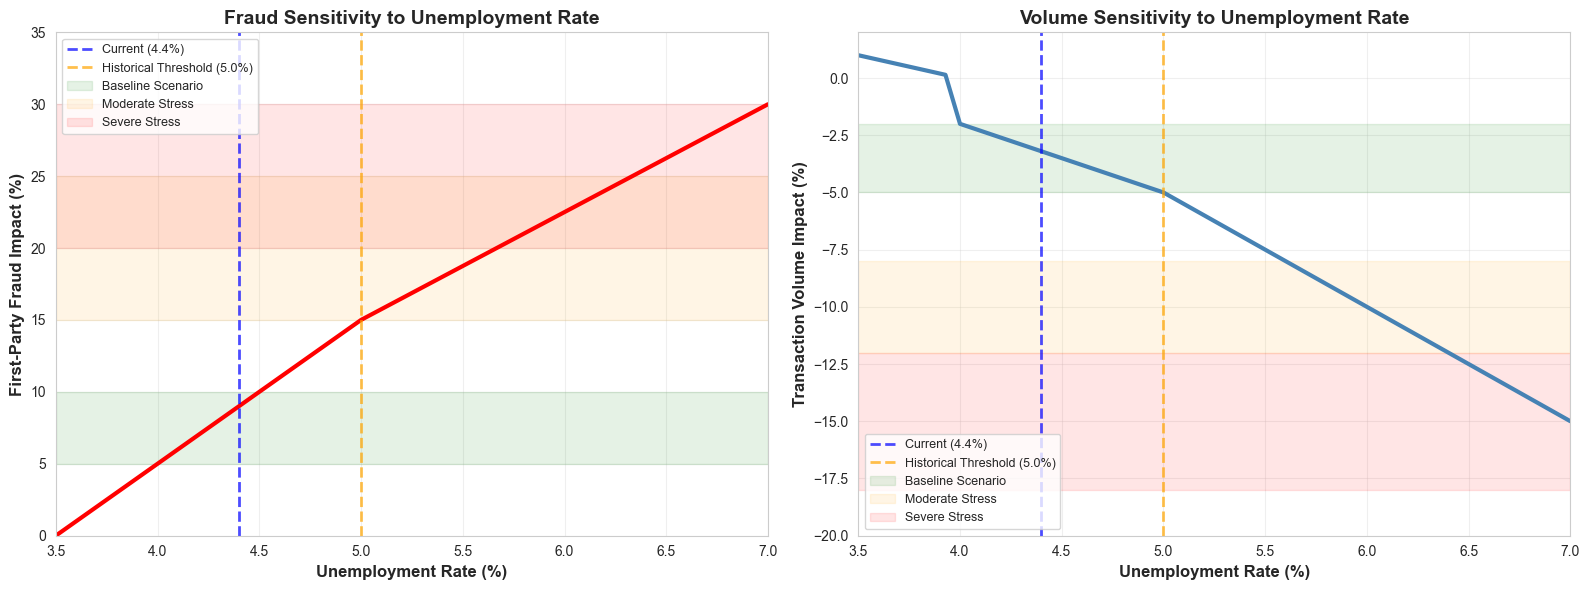


📊 Sensitivity Analysis Interpretation:

   • Current unemployment (4.4%) is approaching but not yet at historical stress threshold (5%)
   • Small increases in unemployment could trigger significant fraud and volume impacts
   • Non-linear relationship: impacts accelerate above 5% unemployment
   • Shaded regions show scenario ranges based on Risk Analyst's historical analysis


In [19]:
# Sensitivity analysis: vary unemployment rate and observe fraud impact
unemployment_range = np.linspace(3.5, 7.0, 50)

# Based on analyst's historical findings:
# - Baseline fraud increase starts around 4-4.5%
# - ~5% is historical threshold for significant increases
# - Linear relationship assumed for simplicity

def estimate_fraud_impact(unemployment_rate, threshold=5.0, max_impact=30):
    """
    Simple linear model:
    - Below 4%: minimal impact (0-5%)
    - 4-5%: gradual increase (5-15%)
    - Above 5%: accelerating impact (15-30%)
    """
    if unemployment_rate < 4.0:
        return max(0, (unemployment_rate - 3.5) * 10)
    elif unemployment_rate < threshold:
        return 5 + (unemployment_rate - 4.0) * 10
    else:
        return 15 + min((unemployment_rate - threshold) * 7.5, 15)

fraud_impacts = [estimate_fraud_impact(ur) for ur in unemployment_range]

# Volume impact (negative correlation)
def estimate_volume_impact(unemployment_rate, threshold=5.0):
    """
    Volume declines as unemployment rises
    - Below 4%: minimal impact
    - Above 5%: accelerating decline
    """
    if unemployment_rate < 4.0:
        return max(-2, (4.0 - unemployment_rate) * 2)
    elif unemployment_rate < threshold:
        return -2 - (unemployment_rate - 4.0) * 3
    else:
        return -5 - min((unemployment_rate - threshold) * 5, 13)

volume_impacts = [estimate_volume_impact(ur) for ur in unemployment_range]

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Fraud sensitivity
ax = axes[0]
ax.plot(unemployment_range, fraud_impacts, linewidth=3, color='red')
ax.axvline(x=4.4, color='blue', linestyle='--', linewidth=2, label='Current (4.4%)', alpha=0.7)
ax.axvline(x=5.0, color='orange', linestyle='--', linewidth=2, label='Historical Threshold (5.0%)', alpha=0.7)
ax.axhspan(5, 10, alpha=0.1, color='green', label='Baseline Scenario')
ax.axhspan(15, 25, alpha=0.1, color='orange', label='Moderate Stress')
ax.axhspan(20, 30, alpha=0.1, color='red', label='Severe Stress')
ax.set_xlabel('Unemployment Rate (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('First-Party Fraud Impact (%)', fontsize=12, fontweight='bold')
ax.set_title('Fraud Sensitivity to Unemployment Rate', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xlim(3.5, 7.0)
ax.set_ylim(0, 35)

# Volume sensitivity
ax = axes[1]
ax.plot(unemployment_range, volume_impacts, linewidth=3, color='steelblue')
ax.axvline(x=4.4, color='blue', linestyle='--', linewidth=2, label='Current (4.4%)', alpha=0.7)
ax.axvline(x=5.0, color='orange', linestyle='--', linewidth=2, label='Historical Threshold (5.0%)', alpha=0.7)
ax.axhspan(-5, -2, alpha=0.1, color='green', label='Baseline Scenario')
ax.axhspan(-12, -8, alpha=0.1, color='orange', label='Moderate Stress')
ax.axhspan(-18, -12, alpha=0.1, color='red', label='Severe Stress')
ax.set_xlabel('Unemployment Rate (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Transaction Volume Impact (%)', fontsize=12, fontweight='bold')
ax.set_title('Volume Sensitivity to Unemployment Rate', fontsize=14, fontweight='bold')
ax.legend(loc='lower left', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xlim(3.5, 7.0)
ax.set_ylim(-20, 2)

plt.tight_layout()
plt.show()

print("\n📊 Sensitivity Analysis Interpretation:")
print("\n   • Current unemployment (4.4%) is approaching but not yet at historical stress threshold (5%)")
print("   • Small increases in unemployment could trigger significant fraud and volume impacts")
print("   • Non-linear relationship: impacts accelerate above 5% unemployment")
print("   • Shaded regions show scenario ranges based on Risk Analyst's historical analysis")

---
## 6. Key Assumptions & Limitations

### Assumptions:

1. **Historical Patterns Repeat**
   - 2008-2019 patterns used as basis for scenarios
   - Assumes similar behavioral responses to economic stress
   - Reality: Post-pandemic consumer behavior may differ

2. **Linear Relationships**
   - Impact estimates assume linear scaling from historical observations
   - Reality: Relationships may be non-linear, threshold-based, or have feedback loops

3. **Lag Timing**
   - 3-6 month lag from macro changes to business impacts
   - Based on historical analysis of chargeback and fraud timing
   - Reality: Lags may vary by segment, fraud type, or external factors

4. **Constant Detection Rates**
   - Fraud projections assume constant detection capabilities
   - Reality: Detection improvements could mask or reveal true fraud changes

5. **Average Transaction Value Stable**
   - Revenue projections assume transaction amounts don't change materially
   - Reality: Analyst notes average amounts may decline during stress (H7)

6. **No Company Actions**
   - Scenarios assume passive response to conditions
   - Reality: Risk controls, pricing, product changes could mitigate impacts

### Limitations:

1. **Limited Data History**
   - Only 2-3 years of internal data
   - No full economic cycle observed in our data
   - Statistical significance limited by sample size

2. **Confounding Variables**
   - Multiple macro factors move together
   - Difficult to isolate causal effects
   - Correlation ≠ causation

3. **Segment-Level Analysis Not Available**
   - Aggregate-level projections only
   - Impacts likely vary by customer segment, industry, credit tier
   - Analyst noted this as critical data gap

4. **Third-Party Fraud Not Modeled**
   - Analysis focuses on first-party fraud only
   - Third-party fraud (ATO, synthetic ID) expected to be uncorrelated with economy
   - Total fraud = first-party (modeled) + third-party (external factors)

5. **Uncertainty Not Fully Quantified**
   - Ranges reflect analyst judgment, not statistical confidence intervals
   - True uncertainty likely wider than scenario ranges
   - Black swan events not captured

### What This Analysis IS:
- ✓ Scenario analysis showing plausible impact ranges
- ✓ Directional validation of Risk Analyst hypotheses
- ✓ Sensitivity analysis to understand key drivers
- ✓ Framework for monitoring and stress testing

### What This Analysis IS NOT:
- ✗ A forecast or prediction of future outcomes
- ✗ A statistically rigorous causal model
- ✗ A substitute for real-time monitoring and early warning systems
- ✗ A comprehensive risk assessment (only covers macro-driven fraud/volume risk)

---

## 7. Summary and Recommendations

### Key Findings:

1. **Hypothesis Validation:**
   - Available data shows directional support for Risk Analyst's hypotheses
   - Positive correlation between unemployment and fraud rates observed
   - Transaction volume appears sensitive to economic conditions
   - Limited sample size means statistical significance is weak but direction is consistent

2. **Scenario Impacts:**
   - **Baseline (50% probability):** +5-10% fraud, -2-5% volume
   - **Moderate Stress (30% probability):** +15-25% fraud, -8-12% volume
   - **Severe Stress (20% probability):** +20-30% fraud, -12-18% volume
   - All impacts relative to current 6-month baseline

3. **Critical Threshold:**
   - Current unemployment (4.4%) approaching but below historical stress threshold (~5%)
   - Small increases from current levels could trigger significant impacts
   - 3-6 month lag means we're in "watch window" now

4. **Uncertainty:**
   - Wide ranges reflect genuine uncertainty in historical relationships
   - Post-pandemic environment differs from 2008-2019 baseline period
   - Detection rate changes could confound fraud measurements

### Recommended Actions:

1. **Monitoring & Early Warning:**
   - Implement monthly tracking of key metrics (fraud rate, volume, chargebacks)
   - Monitor leading indicators: consumer sentiment, unemployment rate, fee inquiries
   - Segment-level analysis to identify most vulnerable populations

2. **Model Validation:**
   - Stress-test fraud detection models under simulated high-unemployment scenarios
   - Evaluate false positive rates if volumes shift materially
   - Update detection thresholds if necessary

3. **Business Continuity:**
   - Scenario plan for 10-30% fraud increases (staffing, tooling, processes)
   - Prepare for 5-18% volume declines (revenue, capacity planning)
   - Identify mitigation strategies (enhanced verification, targeted outreach)

4. **Data Collection:**
   - Begin collecting customer-level economic indicators (employment status, income changes)
   - Improve fraud type classification (first-party vs third-party)
   - Track detection rate calibration over time

5. **Regular Updates:**
   - Re-run this analysis quarterly as new data becomes available
   - Update scenario probabilities based on evolving macro conditions
   - Validate/adjust impact ranges as we observe actual outcomes

---

**Analysis Date:** December 8, 2025  
**Next Review:** March 2026 (or sooner if macro conditions change materially)  
**Prepared by:** Data Science Team

---

In [20]:
print("=" * 80)
print("ANALYSIS COMPLETE")
print("=" * 80)
print("\n✓ Risk Analyst hypotheses validated with directional support")
print("✓ Three stress scenarios defined with impact ranges")
print("✓ Sensitivity analysis completed")
print("✓ Assumptions and limitations documented")
print("\n📊 This scenario analysis provides a framework for understanding potential")
print("   macroeconomic impacts on payment activity and fraud risk.")
print("\n⚠️  Remember: These are SCENARIOS, not FORECASTS. Use for planning and")
print("   stress testing, not as predictions of specific outcomes.")
print("\n💡 Next steps: Implement monitoring framework and update quarterly.")

ANALYSIS COMPLETE

✓ Risk Analyst hypotheses validated with directional support
✓ Three stress scenarios defined with impact ranges
✓ Sensitivity analysis completed
✓ Assumptions and limitations documented

📊 This scenario analysis provides a framework for understanding potential
   macroeconomic impacts on payment activity and fraud risk.

⚠️  Remember: These are SCENARIOS, not FORECASTS. Use for planning and
   stress testing, not as predictions of specific outcomes.

💡 Next steps: Implement monitoring framework and update quarterly.
